# Preprocessing crowd feasibility data

Here, we combine our two batches of crowdsourcing results and, for reasons of extra caution, we remove the following data about the study contributors from further analysis:
- year of birth (column `year_of_birth`), which is replaced by a coarser `age_group` field;
- location (column `nation`) 

In [1]:
%run ../notebook_preamble_Transitions.ipy
import mapping_career_causeways.plotting_utils as plotting_utils

# Crowd feasibility ratings
path_to_val_data_1 = data_folder + 'restricted/validation/nesta_output_16Dec.csv'
path_to_val_data_2 = data_folder + 'restricted/validation/nesta_output_4_Jan_2021.csv'
batch_results = pd.concat([pd.read_csv(path_to_val_data_1), pd.read_csv(path_to_val_data_2)], axis=0)

In [112]:
# Location for exporting the processed data
outputs_folder = f'{data_folder}processed/validation/'
figure_folder = useful_paths.codebase_dir + 'reports/crowd_feasibility_ratings/figures/'

# Set up font sizes
SMALL_SIZE = 13
MEDIUM_SIZE=14
plt.rc('font', size=SMALL_SIZE, family='Arial')
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)

# 1. Summary statistics of the removed fields

Produce summary descriptions about the contributors' year of birth and location, before removing these descriptors from the data.

In [113]:
# Full dataframe of the crowdsourced feasibility ratings
batch_results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70359 entries, 0 to 32024
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   classification_id                 70359 non-null  int64 
 1   subject_ids                       70359 non-null  int64 
 2   origin_id                         70359 non-null  int64 
 3   origin_label                      70359 non-null  object
 4   origin_description                70359 non-null  object
 5   destination_id                    70359 non-null  int64 
 6   destination_label                 70359 non-null  object
 7   destination_description           70359 non-null  object
 8   perfectly_matched_skills          59402 non-null  object
 9   partially_matched_skills          53095 non-null  object
 10  unmatched_skills                  69501 non-null  object
 11  familiarity_with_origin_1-5       70359 non-null  int64 
 12  familiarity_with_d

In [175]:
# All unique 'coders'
unique_coders = batch_results.drop_duplicates('coder_id')
N=len(unique_coders)
print(N)

387


## 1.1 Year of birth

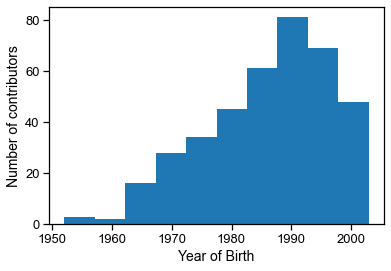

In [125]:
fig, ax = plt.subplots()
ax.hist(unique_coders.year_of_birth)
ax.set_xlabel('Year of Birth')
ax.set_ylabel('Number of contributors')
plotting_utils.export_figure('contributors_year_of_birth', figure_folder=figure_folder, png=True, svg=True)

In [126]:
# Table with all unique years of birth
year_of_birth_df = unique_coders.groupby('year_of_birth').agg({'coder_id': 'count'}).reset_index()
year_of_birth_df.rename(columns={'coder_id': 'counts'}, inplace=True)
# Export
year_of_birth_df.to_csv(outputs_folder + 'contributors_year_of_birth.csv', index=False)

In [127]:
year_of_birth_df

,year_of_birth,counts
0,1952,1
1,1953,1
2,1955,1
3,1960,1
4,1962,1
5,1963,5
6,1964,4
7,1965,4
8,1966,1
9,1967,2


In [159]:
# Summarise age groups
def year_to_age_group(year_of_birth, present_year=2020):
    age = present_year - year_of_birth
    age_group = int(np.floor(age/10)*10)
    age_group = f'{str(age_group)}-{str(age_group+9)}'
    return age_group

year_of_birth_df['age'] = 2020 - year_of_birth_df.year_of_birth
year_of_birth_df['age_group'] = year_of_birth_df['year_of_birth'].apply(lambda x: year_to_age_group(x))
age_groups = year_of_birth_df.groupby('age_group').agg({'counts': 'sum'}).reset_index()
age_groups

,age_group,counts
0,10-19,20
1,20-29,128
2,30-39,127
3,40-49,73
4,50-59,35
5,60-69,4


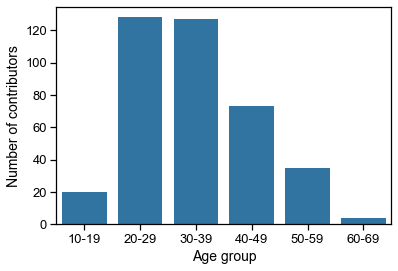

In [160]:
sns.barplot(data=age_groups, x='age_group', y='counts', color='C0')
plt.xlabel('Age group')
plt.ylabel('Number of contributors')
plotting_utils.export_figure('contributors_age_group', figure_folder=figure_folder, png=True, svg=True)

## 1.2 Location

In [130]:
# Table with all unique years of birth
df = unique_coders.groupby('nation').agg({'coder_id': 'count'}).reset_index()
df = df.rename(columns={'coder_id': 'counts'}).sort_values('counts', ascending=False)
# Export
df.to_csv(outputs_folder + 'contributors_nation.csv', index=False)
df

,nation,counts
0,England,334
2,Scotland,31
3,Wales,19
1,Northern Ireland,3


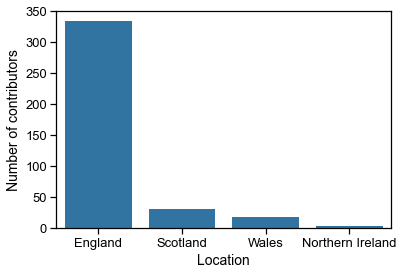

In [140]:
plt.figure(figsize=(6,4))
sns.barplot(data=df, x='nation', y='counts', color='C0')
plt.xlabel('Location')
plt.ylabel('Number of contributors')
plotting_utils.export_figure('contributors_nation', figure_folder=figure_folder, png=True, svg=True)

# 2. Remove fields and export the table

In [166]:
# Convert year of birth to age groups
batch_results_ = batch_results.copy()
batch_results_['age_group'] = batch_results_.year_of_birth.apply(lambda x: year_to_age_group(x))

# Drop the fields
batch_results_ = batch_results_.drop(['year_of_birth', 'nation'], axis=1)

# Export
batch_results_.to_csv(outputs_folder + 'crowd_feasibility_ratings.csv', index=False)

In [171]:
len(batch_results_)

70359

In [170]:
batch_results_.sample(3)

,classification_id,subject_ids,origin_id,origin_label,origin_description,destination_id,destination_label,destination_description,perfectly_matched_skills,partially_matched_skills,...,familiarity_with_destination_1-5,feasibility_1-5,Reasons,coder_id,questionable_respondant_flag,gender,background,highest_qualification,time_stamp,age_group
16336,292289184,52686083,1907,corporate training manager,Corporate training managers coordinate all the...,853,hospitality entertainment manager,Hospitality entertainment managers are in char...,NaN,manage staff; train employees; coordinate even...,...,3,2,"**Skills** - poor skills overlap, missing esse...",b929c3beb0e7ffb1ea4a,False,Male,"['Education','Engineering and research']",Doctorate,NaN,30-39
8206,291143918,52683270,1028,pipeline route manager,Pipeline route managers oversee the day-to-day...,2827,human resources manager,"Human resources managers plan, design and impl...",apply company policies,human resource management; human resources dep...,...,3,1,**Qualifications** - different qualification r...,9fa97ce4c309a3033415,False,Male,"['Construction, transport and security']",GCSE,NaN,30-39
15661,296062351,53140106,1473,welder,\nWelders operate welding equipment in order t...,40,gear machinist,Gear machinists make precision parts for gears...,perform test run; troubleshoot; types of metal...,secure working area; monitor automated machine...,...,5,5,"**Skills** - poor skills overlap, missing esse...",a33630934d5122edc8cb,False,Male,['Other'],Master's degree,2020-12-19 11:22:27+00:00,20-29
